In [26]:
'''
The note book deal with spacer emission probability to get a better understanding of emission prob distribution

1. plot all emission probability on the same scale
2. compare linear and poly regression on emission probability 
3. build new set of parameters on spacer emission probability
'''

## use ipython parallel programming 
from IPython.parallel import Client
rc = Client()
dview = rc[:]


import pandas as pd; dview.execute("import pandas as pd")

import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import matplotlib


import os
# The path where all the GeneMark-ES 4th run models located
modelFilePath = "/home/richard/largeDataSet/ES_Run_modfileAug2015/" 
modelFileNames = os.listdir(modelFilePath)

# full data
fulldata = pd.read_csv("../1_DataSmall/fullTableInfoGff3GffRNAESwithDensity20150829.csv")
fulldata.index = fulldata['shortName']


dview.push({'modelFilePath':modelFilePath,'modelFileNames':modelFileNames})

<AsyncResult: finished>

In [2]:
class ESModelSpacer():
    _GC_PARAM = { # each param is paired with an ending signal
        '$MARKOV_BP_SPACER':'TT'
    }
    
    def __init__(self, filename):
        self.f = open(filename)

    def close(self):
        '''close file connection'''
        self.f.close()
        
    def extract_to_table(self, param, cols = ['X','Y']):
        '''
        Capture data below parameter and output an dataframe
        Right now, only been tested on spacer
        
        '''
        data = []
        switch = False
        for line in self.f:
            if switch:
                data.append(line)
#                 print line
            if param in line:
                switch = True
            if switch and "{}".format(self._GC_PARAM[param]) in line:
                switch = False
                break
        data = map(lambda line: line.rstrip().split(), data)
#         pairs = map(lambda (a,b): (int(a), float(b)), data)
        
        return pd.DataFrame(data, columns= cols) 
    
dview.push({'ESModelSpacer':ESModelSpacer})

<AsyncResult: finished>

In [3]:
test1 = ESModelSpacer(modelFilePath+modelFileNames[0]).extract_to_table("$MARKOV_BP_SPACER")

In [4]:
cols = test1.X #assign column names as dinucleotides

In [5]:
spacer_prob_map = dview.map(lambda filename: ESModelSpacer(modelFilePath+filename).extract_to_table("$MARKOV_BP_SPACER"), modelFileNames)

In [6]:
spacer_probs = spacer_prob_map.get()

In [7]:
df = pd.DataFrame(map(lambda df: df.Y, spacer_probs),dtype=float)

In [8]:
df.columns = cols

In [9]:
## get GC
gc = map(lambda filename: fulldata.loc[filename[:-11]].gc, modelFileNames)

In [10]:
df['gc'] = gc

In [17]:
# adjust font size
matplotlib.rcParams.update({'font.size': 20})

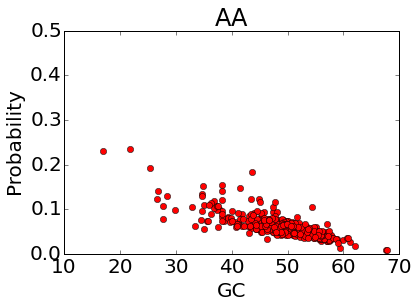

In [18]:
plt.plot(df.gc, df.icol(0),'ro')
plt.title(df.columns[0])
plt.ylim([0,.5])
plt.xlim([10,70])
plt.xlabel('GC')
plt.ylabel('Probability')

In [19]:
df.to_csv('../1_DataSmall/SpacerEmissionProbTable.csv',index=None)

In [20]:
# plot path 
plot_path = "/home/richard/research/1_DataSmall/Plots/spacer_emission/"

In [23]:
for i in range(16):
    plt.plot(df.gc, df.icol(i),'ro')
    plt.title(df.columns[i])
    plt.ylim([0,.3])
    plt.xlim([10,70])
    plt.xlabel('GC')
    plt.ylabel('Probability')
    plt.savefig(plot_path+df.columns[i],bbox_inches='tight')
    plt.close()

In [ ]:
### start poly regression 

In [47]:
# regression set with 1d wrapper, just plug in gc and will output probability
regressModelSet = map(lambda XY: np.poly1d(np.polyfit(df.gc, df[XY],deg = 2)), df.columns)

In [71]:
gc_range = range(20,65)

In [72]:
regressResult = map(lambda model: model(gc_range), regressModelSet)

In [83]:
AA = np.polyfit(df.gc, df.AA, 2)
linearAA = np.polyfit(df.gc, df.AA, 1)

In [84]:
p = np.poly1d(AA)
linearp = np.poly1d(linearAA)

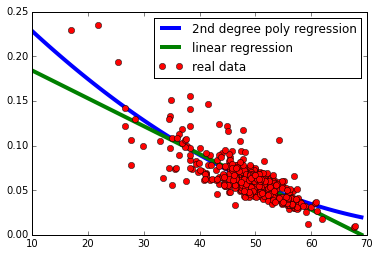

In [86]:
plt.plot(range(10,70),p(range(10,70)), lw = 4, label = '2nd degree poly regression')
plt.plot(range(10,70),linearp(range(10,70)), lw = 4, label = 'linear regression')
plt.plot(df.gc, df.icol(0),'ro',label = 'real data')
plt.legend()

In [76]:
# plot path 
plot_path = "/home/richard/research/1_DataSmall/Plots/spacer_emission_regression/"

In [80]:
for i in range(16):
    plt.plot(df.gc, df.icol(i),'ro',label = 'real data')
    plt.plot(gc_range, regressResult[i], lw = 4, label = '2nd degree poly regression')
    plt.title(df.columns[i])
    plt.ylim([0,.3])
    plt.xlim([10,70])
    plt.xlabel('GC')
    plt.ylabel('Probability')
    plt.legend()
    plt.savefig(plot_path+df.columns[i],bbox_inches='tight')
    plt.close()

In [88]:
## add comparison linear regression
linearRegressModelSet = map(lambda XY: np.poly1d(np.polyfit(df.gc, df[XY],deg = 1)), df.columns)
gc_range = range(20,65)
linearRegressResult = map(lambda model: model(gc_range), linearRegressModelSet)

In [89]:
for i in range(16):
    plt.plot(df.gc, df.icol(i),'ro',label = 'real data')
    plt.plot(gc_range, regressResult[i], lw = 4, label = '2nd degree poly regression')
    plt.plot(gc_range, linearRegressResult[i], lw = 4, label = 'linear regression')
    plt.title(df.columns[i])
    plt.ylim([0,.3])
    plt.xlim([10,70])
    plt.xlabel('GC')
    plt.ylabel('Probability')
    plt.legend()
    plt.savefig(plot_path+df.columns[i],bbox_inches='tight')
    plt.close()